## 16.1 볼린저 밴드

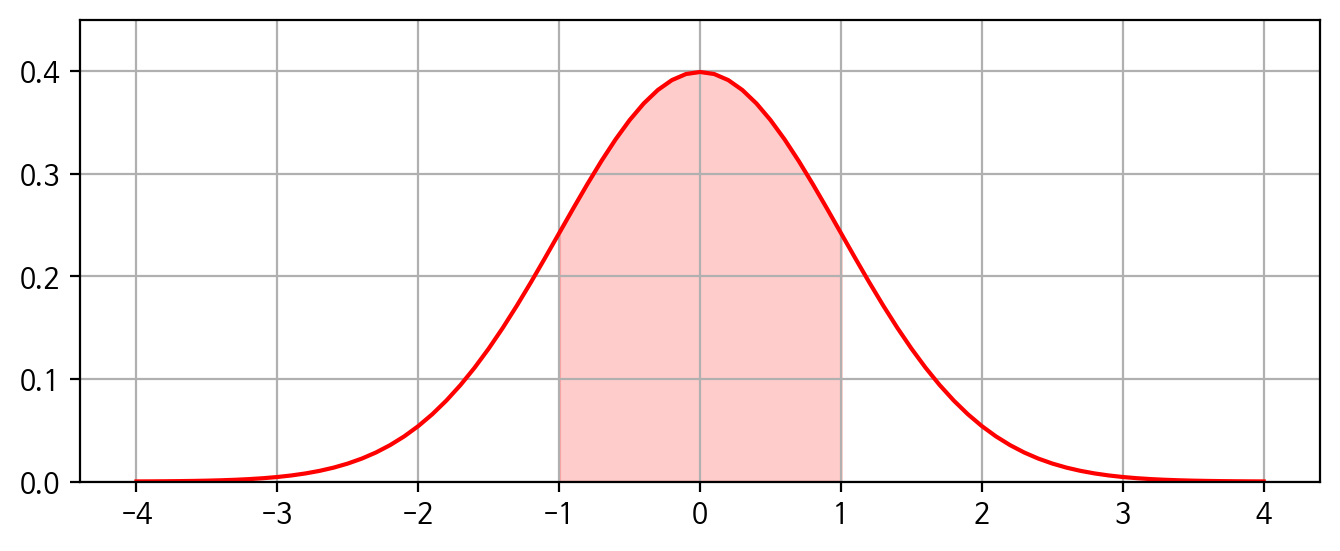

In [8]:
import numpy as np
import matplotlib.pyplot as plt 
plt.rcParams['figure.dpi'] = 200

x = np.linspace(-4, 4, 81)
y = (lambda x: 1/np.sqrt(2*np.pi)/np.exp(x**2/2))(x)

plt.figure(figsize=(8, 3))
plt.grid()
plt.plot(x, y, color="red")
plt.ylim(0, 0.45)
plt.fill_between(x[30:51], y[30:51], alpha=0.2, color='red')

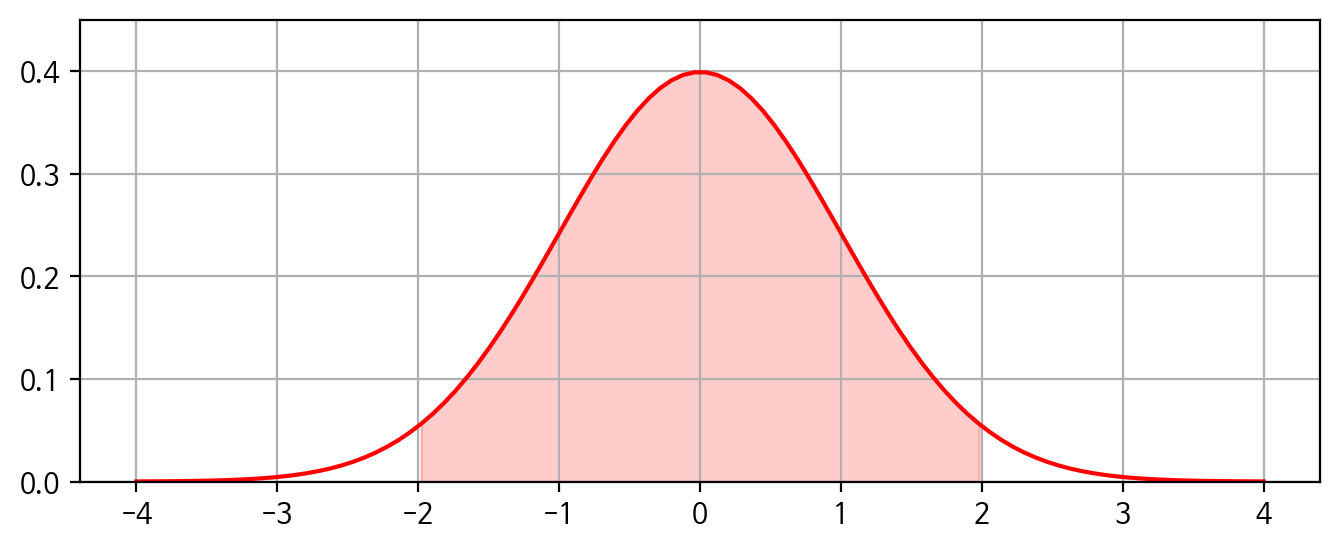

In [9]:
x = np.linspace(-4, 4, 100)
y = (lambda x: 1/np.sqrt(2*np.pi)/np.exp(x**2/2))(x)

plt.figure(figsize=(8, 3))
plt.grid()
plt.plot(x, y, color="red")
plt.ylim(0, 0.45)
plt.fill_between(x[25:75], y[25:75], alpha=0.2, color='red')

In [10]:
from pykrx import stock
from pykrx import bond

tickers = stock.get_market_ticker_list("20190225", market="KOSDAQ")
print(tickers)

[]


In [6]:
from pykrx import stock
from pykrx import bond

df = stock.get_index_ohlcv_by_date("20000101", "20001231", "1001")
df = df[['종가']]
std = df['종가'].rolling(20).std()
df['중심선'] = df['종가'].rolling(20).mean()
df['상단선'] = df['중심선'] + 2 * std
df['하단선'] = df['중심선'] - 2 * std
df.plot(figsize=(12,5))

KeyError: '지수명'

<AxesSubplot:xlabel='날짜'>

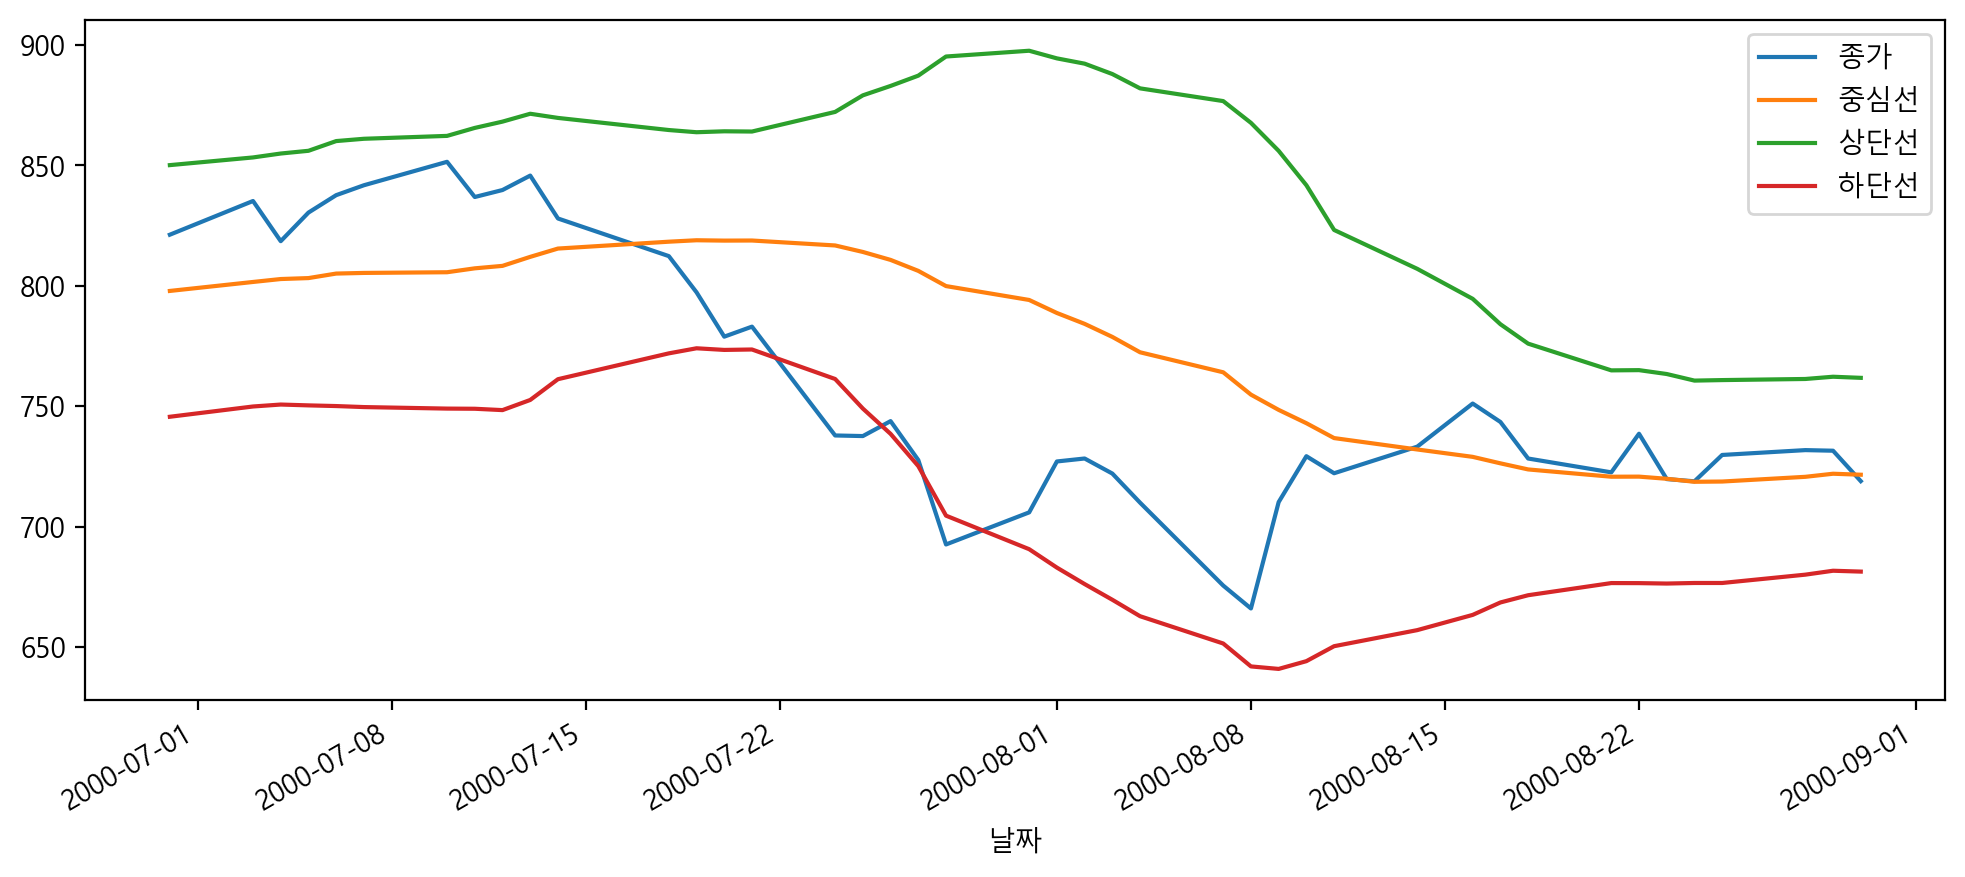

In [8]:
df.loc["20000630":"20000830"].plot(figsize=(12,5))

## 16.2 볼린저 밴드 벡테스팅

In [20]:
from pykrx import stock

df = stock.get_market_ohlcv_by_date("20000101", "20191231", "005930")
df = df[['종가']]

std = df['종가'].rolling(20).std()
df['중심선'] = df['종가'].rolling(20).mean()
df['상단선'] = df['중심선'] + 2 * std
df['하단선'] = df['중심선'] - 2 * std

df['일간수익률'] = df['종가'].pct_change() + 1
df.loc[df['종가'] > df['상단선'], '매매신호'] = False
df.loc[df['종가'] < df['하단선'], '매매신호'] = True

df.loc[df['매매신호'].shift(1) == True, '보유여부'] = True
df.loc[df['매매신호'].shift(1) == False, '보유여부'] = False
df['보유여부'].ffill(inplace=True)
df['보유여부'].fillna(False, inplace=True)

df.iloc[20:].head()

,종가,중심선,상단선,하단선,일간수익률,매매신호,보유여부
날짜,,,,,,,
2000-02-01,5320,5724.0,6163.923438,5284.076562,0.953405,NaN,False
2000-02-02,5250,5707.5,6192.599013,5222.400987,0.986842,NaN,False
2000-02-03,5130,5683.0,6231.993337,5134.006663,0.977143,True,False
2000-02-07,5240,5668.0,6248.910356,5087.089644,1.021442,NaN,True
2000-02-08,5430,5651.0,6239.196172,5062.803828,1.036260,NaN,True


In [21]:
df['보유수익률'] = df.loc[ df['보유여부'] == True, '일간수익률']
df['보유수익률'].fillna(1, inplace=True)
df['누적수익률'] = df['보유수익률'].cumprod()
df.tail()

,종가,중심선,상단선,하단선,일간수익률,매매신호,보유여부,보유수익률,누적수익률
날짜,,,,,,,,,
2019-12-23,55500,52652.5,57662.539920,47642.460080,0.991071,NaN,False,1.0,2.704292
2019-12-24,55000,52812.5,57911.506611,47713.493389,0.990991,NaN,False,1.0,2.704292
2019-12-26,55400,52972.5,58190.028655,47754.971345,1.007273,NaN,False,1.0,2.704292
2019-12-27,56500,53232.5,58614.758868,47850.241132,1.019856,NaN,False,1.0,2.704292
2019-12-30,55800,53507.5,58820.470722,48194.529278,0.987611,NaN,False,1.0,2.704292


<AxesSubplot:xlabel='날짜'>

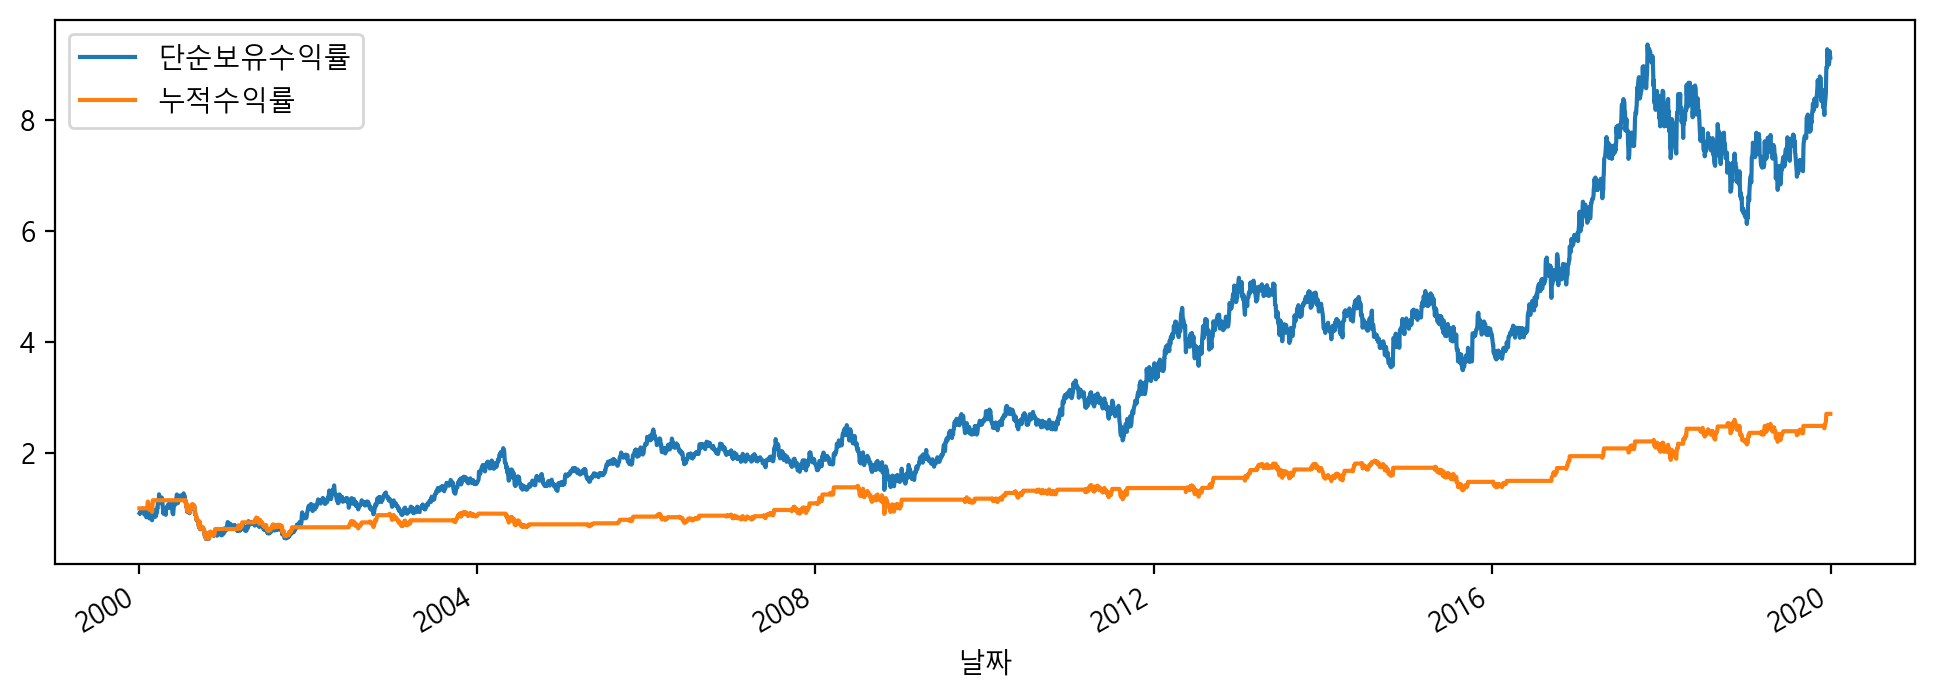

In [24]:
df['단순보유수익률'] = df['일간수익률'].cumprod()
df[['단순보유수익률', '누적수익률']].plot(figsize=(12, 4))

In [26]:
df['누적수익률'][-1] ** (1/20) - 1

0.0509999170814841

In [41]:
delta = df.index[-1] - df.index[0]
year = delta.days/365
print(df['누적수익률'].iloc[-1] ** (1/year) )

1.050999917081484


## 16.3 볼린저 밴드 벡테스팅(전종목)

In [44]:
def 볼린저밴드(df, window=20):
    df = df[['종가']].copy()

    std = df['종가'].rolling(window).std()
    df['중심선'] = df['종가'].rolling(window).mean()
    df['상단선'] = df['중심선'] + 2 * std
    df['하단선'] = df['중심선'] - 2 * std

    df['일간수익률'] = df['종가'].pct_change() + 1
    df.loc[df['종가'] > df['상단선'], '매매신호'] = False
    df.loc[df['종가'] < df['하단선'], '매매신호'] = True

    df.loc[df['매매신호'].shift(1) == True, '보유여부'] = True
    df.loc[df['매매신호'].shift(1) == False, '보유여부'] = False
    df['보유여부'].ffill(inplace=True)
    df['보유여부'].fillna(False, inplace=True)

    df['보유수익률'] = df.loc[ df['보유여부'] == True, '일간수익률']
    df['보유수익률'].fillna(1, inplace=True)
    return df['보유수익률'].cumprod().iloc[-1]

In [51]:
df = stock.get_market_ohlcv_by_date("20000101", "20191231", "005930")

for window in range(5, 10):
    yeild = 볼린저밴드(df, window)
    print(window, yeild)

5 1.0
6 7.766945539658099
7 4.12894318462173
8 7.947036472894267
9 11.982690013436235


In [55]:
import pandas as pd
import os

idx = [ ]
yeild = [ ]
file_list = os.listdir('../ch15/data')
for file in file_list:    
    df = pd.read_excel(f"../ch15/data/{file}")   
    cond = abs(df['종가'].pct_change()) > 0.3
    if len(df[cond]) != 0:
        continue
       
    val = 볼린저밴드(df, 9)
    idx.append(file.split(".")[0])
    yeild.append(val)
    
s = pd.Series(yeild, index=idx)    
s.describe()

count    499.000000
mean       3.426533
std        4.774009
min        0.022063
25%        0.792363
50%        1.828663
75%        3.918551
max       37.588026
dtype: float64

In [53]:
s.idxmax()

'008080.xlsx'